In [1]:
# 导入包
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from scipy import stats
# 数据
train_data=pd.read_csv("/Users/chixinning/Desktop/kaggle/KaggleMyOwn/Mycode/raw_data/train.csv")
train_data.index=train_data["Id"]
train_data.drop("Id", axis=1, inplace=True)

In [2]:
train_data.shape 

(1460, 80)

# 数据预处理
  缺失值

In [3]:

total = train_data.isnull().sum().sort_values(ascending=False)
percent = (train_data.isnull().sum()/train_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print("how many data has missing value = " + str(sum(missing_data['Total'] >= 1)))

how many data has missing value = 19


In [4]:
missing_data.head(20)
# 共有19个缺失值

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageCond,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479


In [5]:
# 如何找到categorical和numerical的特征？
numerical = [f for f in train_data.columns if train_data.dtypes[f] != 'object']
numerical.remove('SalePrice')
print("the count of numerical_features: ",len(numerical))
categorical = [f for f in train_data.columns if train_data.dtypes[f] == 'object']
print("the count of categorical_features: ",len(categorical))
# categorical 和numerical的缺失值
categorical_missing=[f for f in missing_data[:19].index if f in categorical]
numerical_missing=[f for f in missing_data[:19].index if f in numerical]

the count of numerical_features:  36
the count of categorical_features:  43


In [6]:
print("numerical_missing are :",numerical_missing)
print("categorical_missing are :",categorical_missing)

numerical_missing are : ['LotFrontage', 'GarageYrBlt', 'MasVnrArea']
categorical_missing are : ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageCond', 'GarageFinish', 'GarageQual', 'BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'MasVnrType', 'Electrical']


In [7]:
# salePrice为什么要做normal distribution？

In [8]:
# 除了electronic 其余都fillNa('None')
cols = ['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2'
        ,'FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','PoolQC',
        'Fence','MiscFeature','MasVnrType']
for i in cols:
    train_data[i] = train_data[i].fillna('None')

In [9]:
# GarageYrBlt:Year garage was built,虽然是数值型的，但是这个值缺失很可能表示并没有车库这种东西？其中GarageYrBlt为车库的年份，我们用房子的建造年份来替代
train_data["GarageYrBlt"]=train_data["GarageYrBlt"].fillna(train_data['YearBuilt'])

In [10]:
# LotFrontage表示房子临近的街道，参考kaggle上大神的思路：居住在一起的人LotFrontage是相似的，我们将邻居的LotFrontage填充进来；
# Reference:https://zhuanlan.zhihu.com/p/46855142
train_data['LotFrontage'] = train_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x:x.fillna(x.median()))

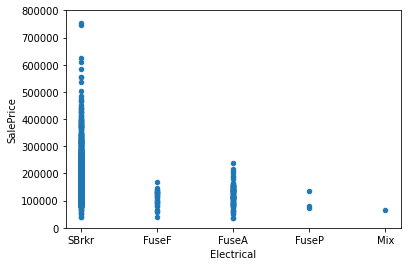

In [11]:
#  Electrical  是有一个缺失值
# 先数据可视化
train_data["Electrical"]=train_data["Electrical"].fillna(train_data["Electrical"].mode()[0]) # 由可视化所以觉得应该使用mode进行填补
data = pd.concat([train_data['SalePrice'], train_data["Electrical"]], axis=1)
data.plot.scatter(x="Electrical", y='SalePrice', ylim=(0,800000));

In [12]:
train_data["MasVnrArea"]=train_data["MasVnrArea"].fillna(0)

'''
BsmtUnfSF:Unfinished square feet of basement area
BsmtFinSF2:Type 2 finished square feet
BsmtFinSF1: Type 1 finished square feet 
TotalBsmtSF: Total square feet of basement area
表示地下室某种面积，直接填充0.
'''

In [13]:

train_data['BsmtUnfSF'] = train_data['BsmtUnfSF'].fillna(0)
train_data['BsmtFinSF2'] = train_data['BsmtFinSF2'].fillna(0)
train_data['BsmtFinSF1'] = train_data['BsmtFinSF1'].fillna(0)
train_data['TotalBsmtSF'] = train_data['TotalBsmtSF'].fillna(0)

In [14]:
# 缺失值check
train_data.isnull().sum().max() 

0

# numerical//categorical Check
因为缺失值处理没有变过所以这里还是36和43.

In [15]:
numerical = [f for f in train_data.columns if train_data.dtypes[f] != 'object']
numerical.remove('SalePrice')
print("the count of numerical_features: ",len(numerical))
categorical = [f for f in train_data.columns if train_data.dtypes[f] == 'object']
print("the count of categorical_features: ",len(categorical))

the count of numerical_features:  36
the count of categorical_features:  43


# categorical -> numerical

  numerical -> categorical

In [16]:
train_data = train_data.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45",50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},"MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}})

In [17]:
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2','Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope', 'PavedDrive', 'Alley')

# 使用循环,编码所选列
  是因为预处理这个地方循环编码错了吗
  反正5.10Ver也错了

In [18]:
train_data=train_data.replace(
{
    # 'Utilities': {'AllPub': 1, 'NoSeWa': 0},
 'ExterQual': {'Ex': 5, 'Fa': 2, 'Gd': 4, 'TA': 3,'Po':1},#只把None设置为0,没有None的最低是1
 'ExterCond': {'Ex': 5, 'Fa': 2, 'Gd': 4, 'TA': 3,'Po':1},
 'BsmtQual': {'Ex': 5, 'Fa': 2, 'Gd': 4, 'TA': 3,'Po':1,'None':0}, 
 'BsmtCond': {'Ex': 5, 'Fa': 2, 'Gd': 4, 'TA': 3,'Po':1,'None':0},
 'BsmtExposure': {'Av': 3, 'Gd': 4, 'Mn': 2, 'No': 1, 'None': 0},
 'BsmtFinType1': {'ALQ': 5,'BLQ': 4,'GLQ': 6,'LwQ': 2,'None': 0,'Rec': 3,'Unf': 1},
 'BsmtFinType2': {'ALQ': 5,'BLQ': 4,'GLQ': 6,'LwQ': 2,'None': 0,'Rec': 3,'Unf': 1},
 'HeatingQC': {'Ex': 5, 'Fa': 2, 'Gd': 4, 'Po': 1, 'TA': 3},
 'KitchenQual': {'Ex': 5, 'Fa': 2, 'Gd': 4, 'Po': 1, 'TA': 3},
 'FireplaceQu': {'Ex': 5, 'Fa': 2, 'Gd': 4, 'Po': 1, 'TA': 3,'None':0},
 'GarageQual': {'Ex': 5, 'Fa': 2, 'Gd': 4, 'Po': 1, 'TA': 3,'None':0},
 'GarageCond': {'Ex': 5, 'Fa': 4, 'Gd': 3, 'None': 2, 'Po': 1, 'TA': 0},
 'PoolQC': {'Ex': 4, 'Fa': 1, 'Gd': 3, 'None': 0,'TA':2},
 'Fence': {'GdPrv': 4, 'GdWo': 2, 'MnPrv': 3, 'MnWw': 1, 'None': 0}})


In [19]:
train_data["PavedDrive"].groupby(train_data["PavedDrive"]).count()

PavedDrive
N      90
P      30
Y    1340
Name: PavedDrive, dtype: int64

In [20]:
train_data=train_data.replace({"Alley":{"Grvl" : 1, "Pave" : 2}})
train_data=train_data.replace({"PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2}})


In [21]:
cols = list(cols)

In [22]:

# from sklearn.preprocessing import LabelEncoder
# for i in cols:
#     le = LabelEncoder()
#     le.fit(list(train_data[i].values))
#     train_data[i] = le.transform(train_data[i].values)

In [23]:
train_data[cols].head()

,FireplaceQu,BsmtQual,BsmtCond,GarageQual,GarageCond,ExterQual,ExterCond,HeatingQC,PoolQC,KitchenQual,BsmtFinType1,BsmtFinType2,Fence,BsmtExposure,GarageFinish,LandSlope,PavedDrive,Alley
Id,,,,,,,,,,,,,,,,,,
1,0,4,3,3,0,4,3,5,0,4,6,1,0,1,RFn,Gtl,2,None
2,3,4,3,3,0,3,3,5,0,3,5,1,0,4,RFn,Gtl,2,None
3,3,4,3,3,0,4,3,5,0,4,6,1,0,2,RFn,Gtl,2,None
4,4,3,4,3,0,3,3,4,0,4,5,1,0,1,Unf,Gtl,2,None
5,3,4,3,3,0,4,3,5,0,4,6,1,0,3,RFn,Gtl,2,None


In [24]:
# numerical//categorical Check
# 经过上面的一波变成了49和30
numerical = [f for f in train_data.columns if train_data.dtypes[f] != 'object']
numerical.remove('SalePrice')
print("the count of numerical_features: ",len(numerical))
categorical = [f for f in train_data.columns if train_data.dtypes[f] == 'object']
print("the count of categorical_features: ",len(categorical))
# 一些时间类型的暂且没有处理。

the count of numerical_features:  49
the count of categorical_features:  30


In [27]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   object 
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [25]:
train_data.to_csv("train_clean_5.10_Ver_withoutEncoded.csv")